# Checking the preprocessed data
In this notebook, we'll analyze the preprocessed datasets to check their quality.

# Imports and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import yaml
from hydra import compose, initialize
from omegaconf import OmegaConf
from netCDF4 import Dataset
from pathlib import Path
from multi_sources.data_processing.multi_source_dataset import MultiSourceDataset
from multi_sources.data_processing.utils import read_variables_dict

/home/cdauvill/inria/multi_sources/multi_sources/data_processing/grid_functions.py:11: UserWarning: XArray, dask, and/or zarr not found, XArrayBilinearResampler won't be available.
  from pyresample.bilinear import NumpyBilinearResampler


In [4]:
# context initialization
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(
        config_name="train",
        # We must specify a trainer and model for hydra, but they won't be used in this notebook.
        overrides=["paths=local", "sources=all_sources", "trainer=1gpu", "model=msvit_8b_d256"],
    )
paths = cfg["paths"]
sources_cfg = cfg["sources"]

In [5]:
sources_cfg

{'tc_primed': {'pmw': {'AMSR2_GCOMW1': {'S4': {'variables': ['TB_36.5H']}}, 'GMI_GPM': {'S1': {'variables': ['TB_36.64H']}}, 'TMI_TRMM': {'S2': {'variables': ['TB_37.0H']}}, 'SSMI_F11': {'S1': {'variables': ['TB_37.0H']}}, 'SSMI_F13': {'S1': {'variables': ['TB_37.0H']}}, 'SSMI_F14': {'S1': {'variables': ['TB_37.0H']}}, 'SSMI_F15': {'S1': {'variables': ['TB_37.0H']}}, 'SSMIS_F16': {'S2': {'variables': ['TB_37.0H']}}, 'SSMIS_F17': {'S2': {'variables': ['TB_37.0H']}}, 'SSMIS_F18': {'S2': {'variables': ['TB_37.0H']}}, 'SSMIS_F19': {'S2': {'variables': ['TB_37.0H']}}}, 'era5': {'variables': ['pressure_msl', 'u_wind_10m', 'v_wind_10m', 'sst'], 'input_only': ['sst']}, 'infrared': {'variables': ['IRWIN']}}}

# Building the dataset
We'll use the ```MultiSourceDataset```, which is a map-style torch ```Dataset``` custom subclass.

In [6]:
# Create the dataset
dataset_dir = paths['preprocessed_dataset']
split = 'train'
included_vars = read_variables_dict(sources_cfg)
dataset = MultiSourceDataset(dataset_dir, split, included_vars)

train: Browsing requested sources and loading metadata...
train: Computing sources availability...
train: Pre-computing the sid to dataframe mapping...


In [7]:
len(dataset)

19595

# Displaying a few samples 
Let's look at the values of a few samples:

In [9]:
rng = np.random.default_rng(17)
indices = rng.integers(low=0, high=len(dataset), size=10)
samples = [dataset[i] for i in indices]

In [10]:
n_sources = len(dataset.sources)

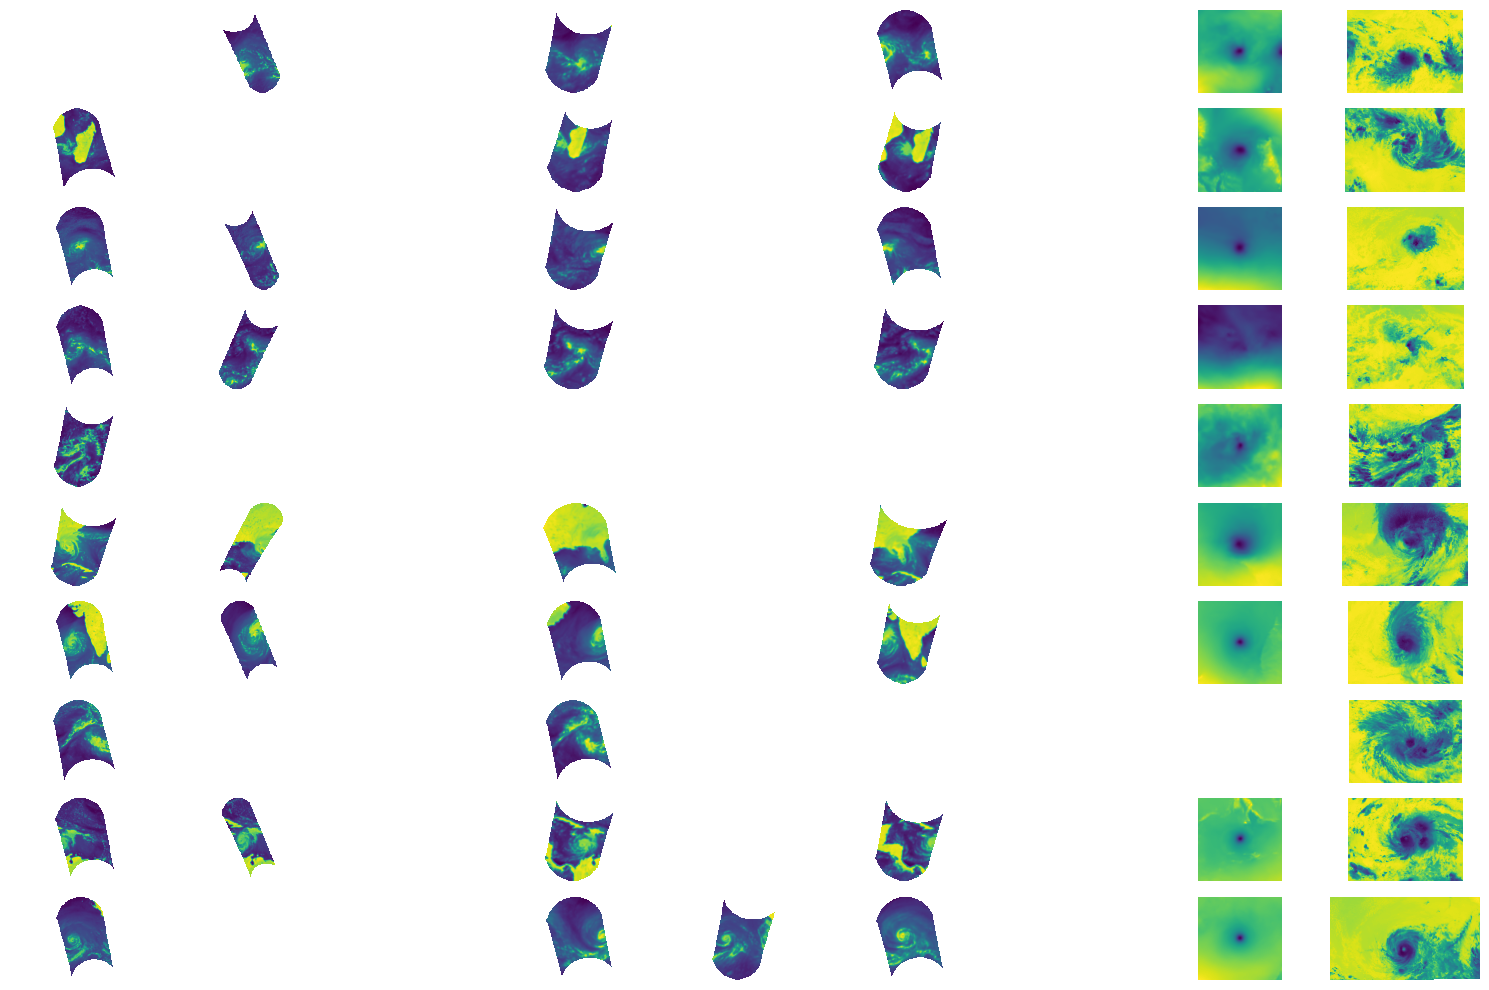

In [11]:
fig, axes = plt.subplots(nrows=len(samples), ncols=n_sources, figsize=(15, 10))

for i, sample in enumerate(samples):
    for j, source in enumerate(dataset.sources):
        ax = axes[i, j]
        if source.name in sample:
            ax.imshow(sample[source.name]['values'][0])
        ax.axis('off')

plt.tight_layout()
plt.show()

## Composition
Let's check which sources are available.

In [12]:
print("Available sources:")
for sn in sample:
    print(sn)

Available sources:
tc_primed_pmw_AMSR2_GCOMW1_S4
tc_primed_pmw_SSMIS_F16_S2
tc_primed_pmw_SSMIS_F17_S2
tc_primed_pmw_SSMIS_F18_S2
tc_primed_era5
tc_primed_infrared


## Coordinates and land mask
Let's select any source and look at the coordinates.

In [13]:
sources = list(sample.keys())
print("Available sources:", sources)

Available sources: ['tc_primed_pmw_AMSR2_GCOMW1_S4', 'tc_primed_pmw_SSMIS_F16_S2', 'tc_primed_pmw_SSMIS_F17_S2', 'tc_primed_pmw_SSMIS_F18_S2', 'tc_primed_era5', 'tc_primed_infrared']


In [14]:
any_source = sample[sources[1]]

The ```coords``` tensor contains the latitude and longitude as the two channels of an image:

tensor(0.2283)


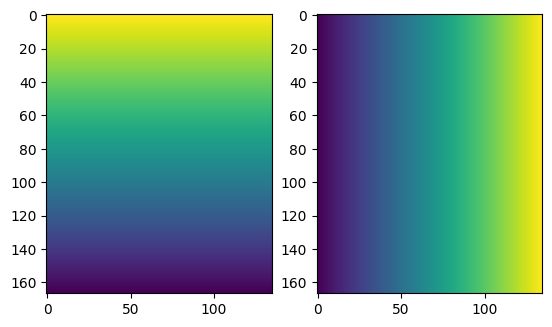

In [15]:
c = any_source['coords']
lat, lon = c[0], c[1]
plt.subplot(121)
plt.imshow(lat)
plt.subplot(122)
plt.imshow(lon)
# Time coordinate
print(any_source['dt'])

```landmask``` is the land-sea mask:

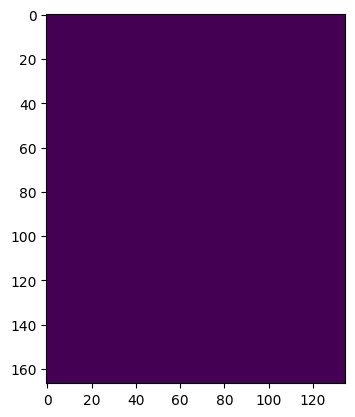

In [16]:
plt.imshow(any_source['landmask'])

## Characteristic variables
Each source has its own set of characteristic variables, which characterize the source within its source type. Therefore, all sources of a common type implement the same characteristic variables, with different values. For example, the frequency can differ between passive microwave images.   

In [17]:
# Prints the normalized characteristics of the source
any_source['characs']  # freq, IFOV_nadir_along_track, IFOV_nadir_across_track, IFOV_edge_along_track, IFOV_edge_across_track

tensor([0.1467, 0.5731, 0.3552, 0.2924, 0.0797])

## Values
Let's now look at the values (i.e. the observation themselves).

In [18]:
v = any_source['values']
v.shape

torch.Size([1, 167, 135])

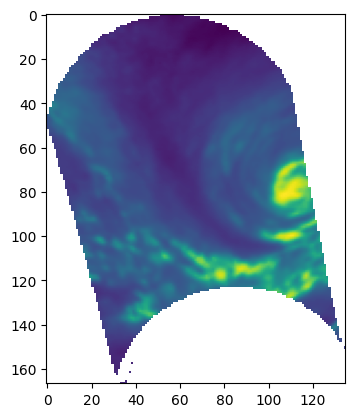

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=v.shape[0], squeeze=False)
for i in range(v.shape[0]):
    axes[0, i].imshow(v[i])